In [4]:
import numpy as np
import json
import scipy.stats
import matplotlib.pyplot as plt
from collections import Counter
import math
import operator
from PIL import Image, ImageDraw

In [5]:
import json

file_path = 'C:\\Users\\David\\Desktop\\trafficandpdes\\data_demo\\first1000_data.json'

try:
    with open(file_path, 'r') as json_file:
        data_dict = json.load(json_file)
    # Process your data here
except FileNotFoundError:
    print("File not found:", file_path)

with open('C:\\Users\\David\\Desktop\\trafficandpdes\\data_demo\\speed_data1000.json', 'r') as json_file:
    speed_dict = json.load(json_file)


In [6]:
speeds = []

for entry in data_dict:

    # sanity check
    assert(len(entry['timestamp']) == len(entry['x_position']))

    # times
    time_secs = entry['timestamp']
    sec_diff = np.diff(time_secs)
    time_hrs = np.array(time_secs)/3600
    hr_diff = np.diff(time_hrs)

    # distances
    distance_feet = entry['x_position']
    feet_diff = np.diff(distance_feet)
    distance_miles = np.array(distance_feet)/5280
    mile_diff = np.diff(distance_miles)

    # speeds
    # Note: the length of the speed array is one less than the length of the time array
    average_speeds = feet_diff / sec_diff # ft/sec
    average_mph = mile_diff/hr_diff # mile/hr

    # create a dictionary to store the id and the speed
    id_speed = {}
    id_speed['_id'] = entry['_id']
    id_speed['speed'] = list(average_speeds)

    speeds.append(id_speed)



In [7]:
speed_data_path = "speed_data1000.json" # name and location of json file after it's saved
with open(speed_data_path, 'w') as f:
    json.dump(speeds, f)

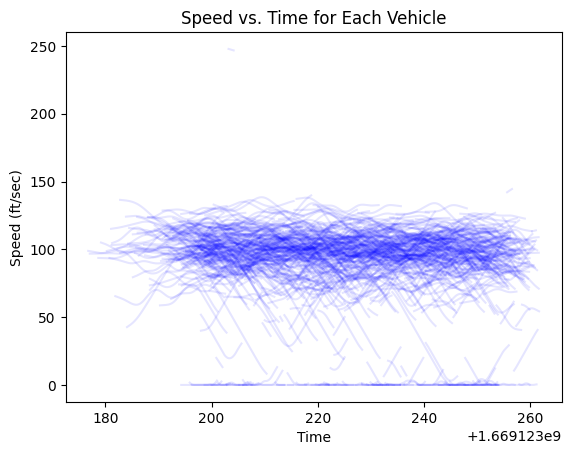

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Iterate over entries in data_dict
for entry in data_dict:
    # Sanity check
    assert(len(entry['timestamp']) == len(entry['x_position']))
    
    # Times
    time_secs = entry['timestamp']
    sec_diff = np.diff(time_secs)

    # Distances
    distance_feet = entry['x_position']
    feet_diff = np.diff(distance_feet)

    # Speeds
    average_speeds = feet_diff / sec_diff  # ft/sec
    # This is .
    
    plt.plot(time_secs[:-1], average_speeds, color='blue', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Speed (ft/sec)')
plt.title('Speed vs. Time for Each Vehicle')
plt.show()




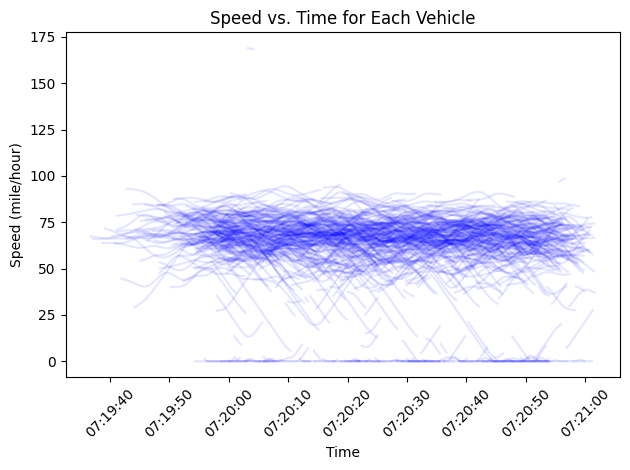

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # Import the module for date formatting
from datetime import datetime

# Convert feet per second to miles per hour
def feet_per_sec_to_miles_per_hour(feet_per_sec):
    return feet_per_sec * 0.681818

# Iterate over entries in data_dict
for entry in data_dict:
    # Sanity check
    assert len(entry['timestamp']) == len(entry['x_position'])
    
    # Times
    time_secs = entry['timestamp']
    sec_diff = np.diff(time_secs)

    # Distances
    distance_feet = entry['x_position']
    feet_diff = np.diff(distance_feet)

    # Speeds
    average_speeds = feet_diff / sec_diff  # ft/sec
    average_speeds_mph = feet_per_sec_to_miles_per_hour(average_speeds)  # Convert to mph
    
    # Convert timestamps to datetime objects
    time_dt = [datetime.fromtimestamp(ts) for ts in time_secs[:-1]]
    
    plt.plot(time_dt, average_speeds_mph, color='blue', alpha=0.1)

# Format the x-axis tick labels as '%H:%M:%S'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xticks(rotation=45)  # Rotate tick labels
#plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
plt.xlabel('Time')
plt.ylabel('Speed (mile/hour)')
plt.title('Speed vs. Time for Each Vehicle')
plt.tight_layout() 
plt.show()



In [10]:
import ijson
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime

In [11]:
# Compute the longitudinal speed using numerical differentiation of the x_position, 
#   i.e., v = dx/dt. np.diff() computes the first-order numerical derivative.
# Multiply by record["direction"] to indicate the direction, 
#   i.e., negative speed means traveling westbound, and positive speed means traveling eastbound.
speed = np.diff(entry['x_position'])/np.diff(entry["timestamp"])*entry["direction"]

# Speed array is truncated by one after the numerical differentiation np.diff(). 
# Append the first item to the array such that the speed array is the same length as the x_position array.
speed = np.append(speed[0], speed) 

# Convert unit from ft/sec to mph
speed *= 0.681818

# Print the first 10 records of speed
print(f"Speed (mph): {speed[:10]}")

# Similarly, compute the 2nd-order numerical differentiation of the x_position to obtain acceleration. 
# np.diff(record["x_position"], n=2) means the second order differentation of x_position.
# The unit for acceleration is ft/sec^2.
accel = np.diff(entry["x_position"], n=2)/(np.diff(entry["timestamp"][:-1])**2)*entry["direction"]
print(f"Acceleration (ft/sec^2): {accel[:10]}")

Speed (mph): [69.0148544  69.0148544  69.01700355 69.01873521 69.02045567 69.02216108
 69.02384879 69.02510581 69.02716619 69.02879668]
Acceleration (ft/sec^2): [0.06371794 0.06349442 0.06308355 0.06253192 0.06188276 0.0611764
 0.060461   0.05978455 0.05919705 0.05874819]


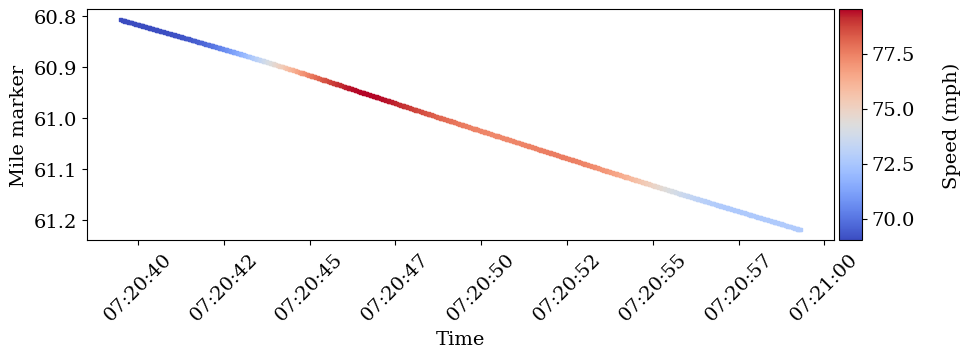

In [12]:
# Set up the plot
plt.rc('font', family='serif', size=14)
fig, ax = plt.subplots(figsize=(10,3))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)

# Plot the position (y-axis) vs. time (x-axis), colored by the speed.
# Position in ft is converted to mile-marker by dividing 5280.
trajectory_times = entry["timestamp"]
trajectory_xvals = np.array(entry["x_position"])/5280
im = ax.scatter(trajectory_times, trajectory_xvals, c=speed, cmap='coolwarm', marker='s', s=5) 
plt.colorbar(im, cax=cax).set_label('Speed (mph)', rotation=90, labelpad=20)
ax.set_xlabel("Time")
ax.set_ylabel("Mile marker")
# -------------------------------------------------------------------

# Update x-axis time format
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
x_datetime = [datetime.datetime.fromtimestamp(ts) for ts in ticks_loc]
labels = [d.strftime('%H:%M:%S') for d in x_datetime]
ax.set_xticklabels(labels, rotation=45)

# Invert vertically
ax.invert_yaxis()

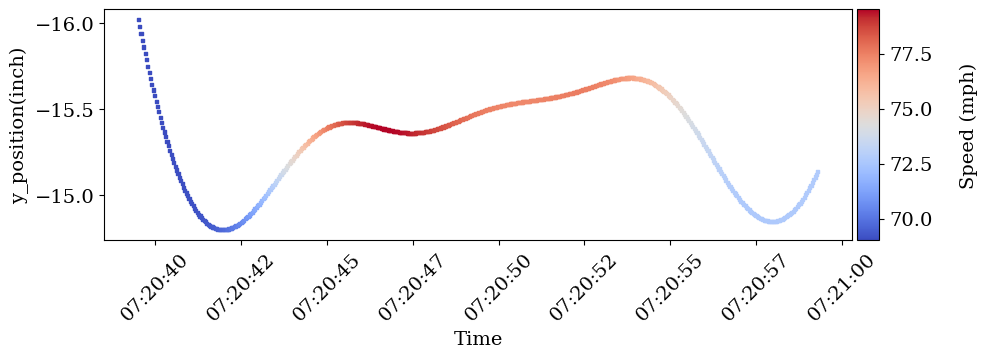

In [13]:
import time
# Set up the plot
plt.rc('font', family='serif', size=14)
fig, ax = plt.subplots(figsize=(10,3))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)

# -------------------------------------------------------------------
# Plot the position (y-axis) vs. time (x-axis), colored by the speed.
# Position in ft is converted to mile-marker by dividing 5280.
trajectory_times = entry["timestamp"]
trajectory_yvals = np.array(entry["y_position"])  # Change here
im = ax.scatter(trajectory_times, trajectory_yvals, c=speed, cmap='coolwarm', marker='s', s=5) 
plt.colorbar(im, cax=cax).set_label('Speed (mph)', rotation=90, labelpad=20)
ax.set_xlabel("Time")
ax.set_ylabel("y_position(inch)")  # Change here
# -------------------------------------------------------------------

# Update x-axis time to readable format
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
x_datetime = [datetime.datetime.fromtimestamp(ts) for ts in ticks_loc]
labels = [d.strftime('%H:%M:%S') for d in x_datetime]
ax.set_xticklabels(labels, rotation=45)

# Invert vertically
ax.invert_yaxis() 


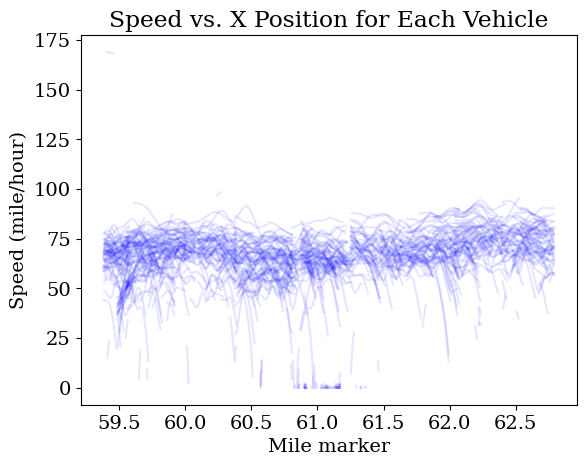

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Convert feet per second to miles per hour
def feet_per_sec_to_miles_per_hour(feet_per_sec):
    return feet_per_sec * 0.681818

# Iterate over entries in data_dict
for entry in data_dict:
    # Sanity check
    assert(len(entry['timestamp']) == len(entry['x_position']))
    
    # Positions
    x_position = entry['x_position']

    # Times
    time_secs = entry['timestamp']
    sec_diff = np.diff(time_secs)

    # Distances
    distance_feet = entry['x_position']
    feet_diff = np.diff(distance_feet)

    # Speeds
    average_speeds = feet_diff / sec_diff  # ft/sec
    average_speeds_mph = feet_per_sec_to_miles_per_hour(average_speeds)  # Convert to mph
    
    # Plot x_position vs. speed
    x = np.array(x_position[1:])/5280
    plt.plot(x, average_speeds_mph, color='blue', alpha=0.1)

plt.xlabel('Mile marker')
plt.ylabel('Speed (mile/hour)')
plt.title('Speed vs. X Position for Each Vehicle')

plt.show()


18020


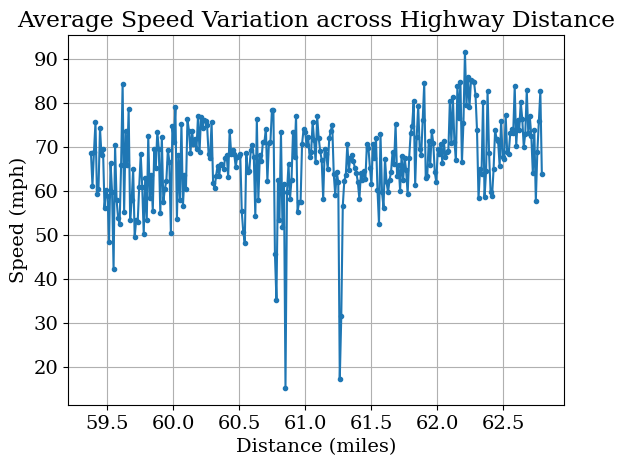

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
# distance/ speed plot
# calculating speed distribution on the highway
mph60 = 60*5280/3600
mph65 = 65*5280/3600
mph70 = 70*5280/3600
mph75 = 75*5280/3600
car_distributions = []
for i in range(len(speed_dict)):
    speed_distributions = {'<60mph': [],'60-65mph':[], '65-70mph' :[], '70-75mph' : [], '>75mph':[]}
    id = speed_dict[i]['_id']
    speeds = speed_dict[i]['speed']
    distances = data_dict[i]['x_position'][1:]
    
    for j in range(len(speeds)):
        if speeds[j] < mph60:
            speed_distributions['<60mph'].append(distances[j])
        elif speeds[j] < mph65:
            speed_distributions['60-65mph'].append(distances[j])
        elif speeds[j] < mph70:
            speed_distributions['65-70mph'].append(distances[j])
        elif speeds[j] < mph75:
            speed_distributions['70-75mph'].append(distances[j])
        else:
            speed_distributions['>75mph'].append(distances[j])
    
    car_distributions.append({'_id': id, 'speed_distribution': speed_distributions})

car_distributions = np.array(car_distributions)

# speed variation accross highway
distance_counts = {}
for i in range(len(data_dict)):
    id = data_dict[i]['_id']
    speeds = speed_dict[i]['speed']
    distances = data_dict[i]['x_position'][1:]
    
    for j in range(len(distances)):
        dist = math.floor(distances[j])
        if distances[j] not in distance_counts.keys():
            distance_counts[dist] = Counter({speeds[j]: 1})
        else:
            distance_counts[dist][speeds[j]] += 1
    

# averaging speed at each point
distance_averages = {}
for distance, speed_counts in distance_counts.items():
    mean_speed = 0
    total = 0
    for speed, count in speed_counts.items():
        mean_speed += (count*speed)
        total += count
    mean_speed /= total
    distance_averages[distance] = mean_speed

distance_averages = dict(sorted(distance_averages.items(), key=operator.itemgetter(0)))
distances = list(distance_averages.keys())
speeds = list(distance_averages.values())
distances_sorted = sorted(distances)
distances = np.array(distances)/ 5280
print(len(distances))
speeds = np.array(speeds)*3600/5280




f = interp1d(distances, speeds, kind='cubic')
distances_smooth = np.linspace(distances.min(), distances.max(), 300)
speeds_smooth = f(distances_smooth)

plt.plot(distances_smooth, speeds_smooth, linewidth=1.5, color='tab:blue', marker='o', markersize=3)
plt.title('Average Speed Variation across Highway Distance')
plt.xlabel('Distance (miles)')
plt.ylabel('Speed (mph)')
plt.grid(True)
plt.show()

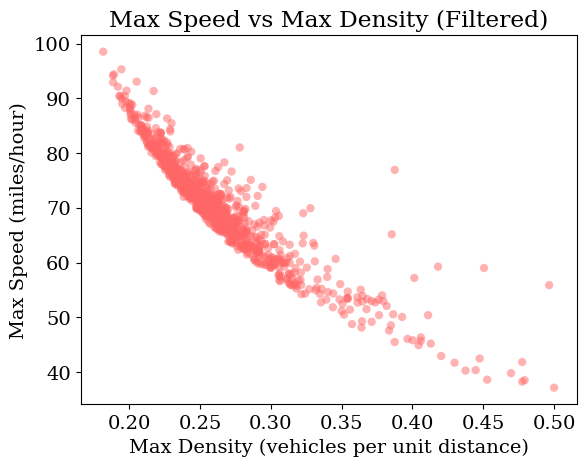

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def feet_per_sec_to_miles_per_hour(feet_per_sec):
    return feet_per_sec * 0.681818

max_speeds = []
max_densities = []

for entry in data_dict:
    #check
    assert(len(entry['timestamp']) == len(entry['x_position']))
    
    # Positions
    x_position = entry['x_position']

    # Times
    time_secs = entry['timestamp']
    sec_diff = np.diff(time_secs)

    # Distances
    distance_feet = entry['x_position']
    feet_diff = np.diff(distance_feet)

    # Speeds
    average_speeds = feet_diff / sec_diff  # ft/sec
    average_speeds_mph = feet_per_sec_to_miles_per_hour(average_speeds)  # Convert to mph
    
    # max speed for this entry
    max_speed = np.max(average_speeds_mph)
    max_speeds.append(max_speed)

    # density
    density = len(x_position) / (np.max(x_position) - np.min(x_position))  # Vehicles per unit distance
    max_densities.append(density)

# Filter data to remove points with max speed > 100 mph and density > 0.5
filtered_data = [(speed, density) for speed, density in zip(max_speeds, max_densities) if speed <= 100 and density <= 0.5]
max_speeds_filtered, max_densities_filtered = zip(*filtered_data)

# Count the number of points at each position
position_counts = {}
for x, y in zip(max_densities_filtered, max_speeds_filtered):
    position_counts[(x, y)] = position_counts.get((x, y), 0) + 1

# Plotting maximum speed vs maximum density without outliers
for position, count in position_counts.items():
    x, y = position
    color = (1, 0.5 - count / 10, 0.5 - count / 10)  # Adjust the color based on count
    plt.scatter(x, y, color=color, alpha=0.5, edgecolor='none')

plt.xlabel('Max Density (vehicles per unit distance)')
plt.ylabel('Max Speed (miles/hour)')
plt.title('Max Speed vs Max Density (Filtered)')

plt.show()


In [17]:
max(time_secs) - min(time_secs)


19.800000190734863

The curve shows a negative correlation between speed and density. As the density of vehicles increases, the maximum speed that can be achieved decreases. This is because as there are more vehicles on the road, there is less space for each vehicle to travel freely. This can lead to congestion and slower speeds.

### The Discretization of the LWR Model ###

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


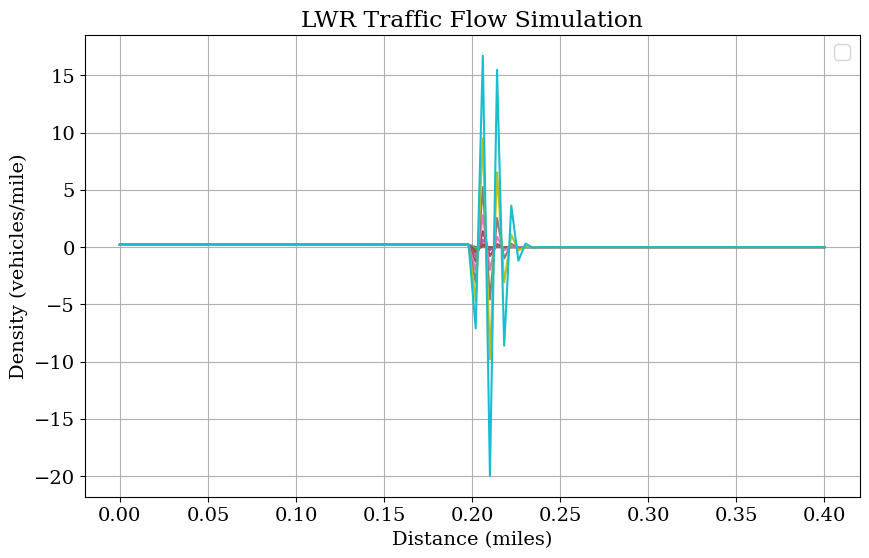

In [80]:
import numpy as np
import matplotlib.pyplot as plt

L = 0.4  # Length of the road (miles)
nx = 100  # Number of spatial grid points
dx = L / nx  # Spatial grid spacing (miles)
T = (max(time_secs)-min(time_secs))/3600  # Total simulation time (hours)
nt = 20  # Number of time steps
dt = T / nt  # Time step size (hours)
v_max = 100  # Maximum velocity (miles/hour)
rho_max = 31.0686  # Maximum density (vehicles/mile)

# Initial condition: density profile
rho_initial = np.zeros(nx)
rho_initial[:int(0.5 * nx)] = 0.2 # Initial density in the first half of the road (vehicles/mile)

# Function to compute flux (velocity-density relation)
def compute_flux(rho):
    return v_max * (1 - rho / rho_max)

# Discretize LWR model using finite differences
def discretize_LWR(rho_initial, nt, dt, dx):
    rho_hist = [rho_initial.copy()]
    rho = rho_initial.copy()
    for n in range(1, nt):
        rho_n = rho.copy()
        F = compute_flux(rho)
        for i in range(1, nx):
            rho[i] = rho_n[i] - dt / dx * (F[i] - F[i - 1])
        rho_hist.append(rho.copy())
    return rho_hist

# Run simulation
rho_hist = discretize_LWR(rho_initial, nt, dt, dx)

# Plot results
plt.figure(figsize=(10, 6))
for i in range(0, nt, nt // 10):
    plt.plot(np.linspace(0, L, nx), rho_hist[i])
    #plt.plot(np.linspace(0, L, nx), rho_hist[i], label=f'Time = {i*dt:.1f} hours')
plt.xlabel('Distance (miles)')
plt.ylabel('Density (vehicles/mile)')
plt.title('LWR Traffic Flow Simulation')
plt.legend()
plt.grid(True)
plt.show()

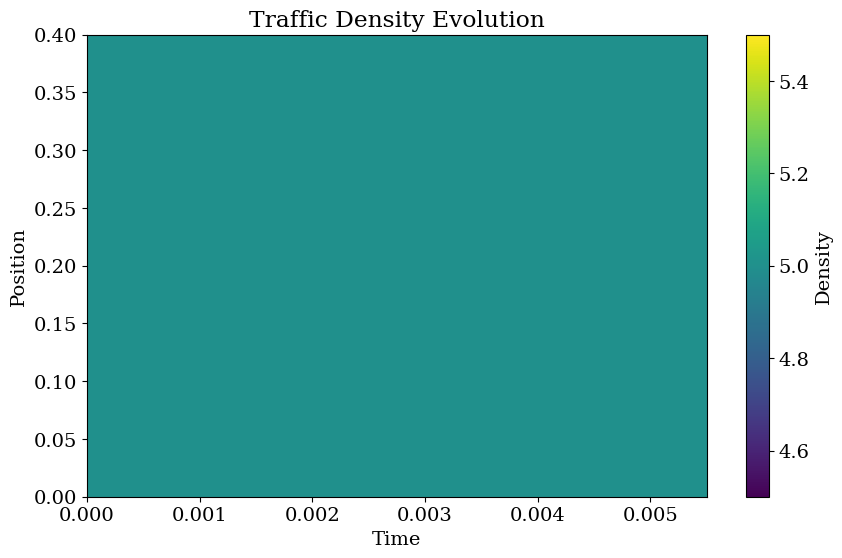

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Define functions
def velocity(rho, rho_max, V_max):
    return V_max * (1 - rho / rho_max)

def dV_drho(rho, rho_max, V_max):
    return - V_max / rho_max

def q(rho, rho_max, V_max):
    return rho * velocity(rho, rho_max, V_max)

def equations(rho, rho_prev, dx, dt, rho_max, V_max):
    """
    Define the equations to solve for each grid point.
    """
    d_rho_dt = np.zeros_like(rho)
    for i in range(1, len(rho) - 1):
        d_rho_dt[i] = (q(rho[i], rho_max, V_max) - q(rho[i-1], rho_max, V_max)) / dx
    
    # Boundary conditions (periodic)
    d_rho_dt[0] = (q(rho[0], rho_max, V_max) - q(rho[-2], rho_max, V_max)) / dx
    d_rho_dt[-1] = (q(rho[-1], rho_max, V_max) - q(rho[-2], rho_max, V_max)) / dx
    
    return d_rho_dt

def lwr_simulation(nx, L, T, dx, dt, rho_max, V_max, rho_initial):
    """
    Perform LWR simulation.
    """
    # Initialize arrays
    rho = np.zeros((nx, int(T/dt)+1))
    rho[:, 0] = rho_initial
    
    # Iterate through time steps
    for t in range(1, int(T/dt)+1):
        rho_prev = np.copy(rho[:, t-1])
        rho[:, t] = fsolve(equations, rho_prev, args=(rho_prev, dx, dt, rho_max, V_max))
    
    return rho

# Parameters
nx = 100  # Number of spatial grid points
L = 0.4  # Length of the road
T = (max(time_secs)-min(time_secs))/3600  # Total simulation time
dx = L / nx  # Spatial step size
dt = T / nt  # Temporal step size
rho_max = 31.0686  # Maximum density
V_max = 100.0  # Maximum velocity
rho_initial = np.ones(nx) * 5.0  # Initial density profile


# Run simulation
rho_history = lwr_simulation(nx, L, T, dx, dt, rho_max, V_max, rho_initial)

# Plotting
x = np.linspace(0, L, nx)
t = np.linspace(0, T, int(T/dt)+1)

plt.figure(figsize=(10, 6))
plt.imshow(rho_history, origin='lower', aspect='auto', extent=[0, T, 0, L])
plt.colorbar(label='Density')
plt.title('Traffic Density Evolution')
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()


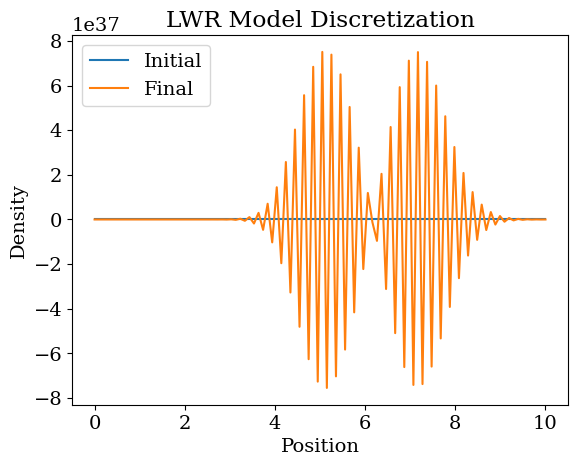

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 10.0  # Length of the road
nx = 100  # Number of spatial grid points
dt = 0.01 # Time step
T = 5.0   # Total simulation time
v_max = 1.0  # Maximum velocity
rho_max = 1.0  # Maximum density
rho_in = 0.6  # Inflow density
rho_out = 0.1 # Outflow density

# Spatial grid
dx = L / nx
x = np.linspace(0, L, nx)

# Initial condition
rho0 = np.zeros(nx)
rho0[int(0.1*nx):int(0.3*nx)] = rho_in

# Function to compute flux
def compute_flux(rho):
    return v_max * (1 - rho / rho_max)

# Time integration using finite differences
rho = np.copy(rho0)
for t in np.arange(0, T, dt):
    rho_next = np.copy(rho)
    for i in range(1, nx-1):
        flux_left = compute_flux(rho[i-1])
        flux_right = compute_flux(rho[i])
        rho_next[i] = rho[i] - dt / dx * (flux_right - flux_left)
    rho = np.copy(rho_next)
    
# Plot results
plt.plot(x, rho0, label='Initial')
plt.plot(x, rho, label='Final')
plt.xlabel('Position')
plt.ylabel('Density')
plt.title('LWR Model Discretization')
plt.legend()
plt.show()


# Regression

Mean Squared Error: 15.687099528441898


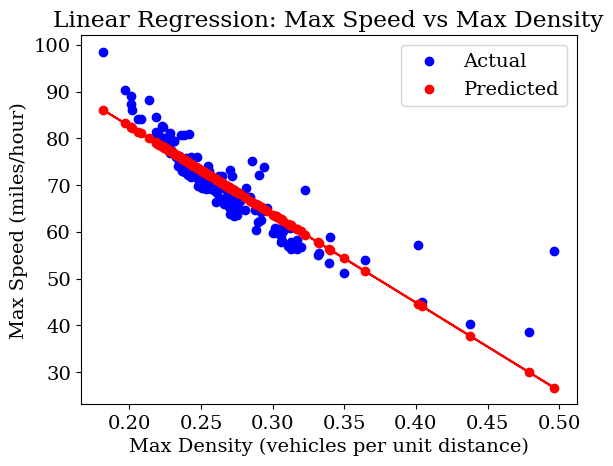

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming max_speeds_filtered and max_densities_filtered are already defined

# Convert lists to numpy arrays
X = np.array(max_densities_filtered).reshape(-1, 1)  # Feature: Max Density
y = np.array(max_speeds_filtered)  # Target: Max Speed

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Plotting the regression line
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', label='Predicted')
plt.plot(X_test, y_pred, color='red')
plt.xlabel('Max Density (vehicles per unit distance)')
plt.ylabel('Max Speed (miles/hour)')
plt.title('Linear Regression: Max Speed vs Max Density')
plt.legend()
plt.show()


In [20]:
# Print the coefficients and intercept of the linear regression model
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
# Calculate R-squared
r_squared = model.score(X_test, y_test)
print("R-squared:", r_squared)


Coefficients: [-188.62472701]
Intercept: 120.34406219323833
R-squared: 0.7921044307217078


Mean Squared Error (Transformed): 7.880598656932706


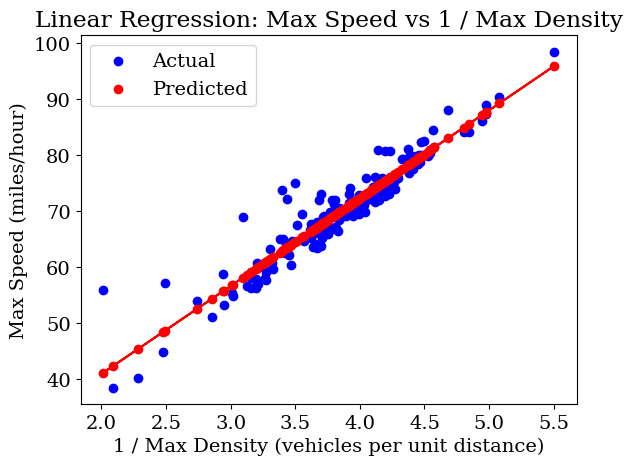

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming X_train, y_train, X_test, y_test are already defined

# Transform X_train to 1/X_train
X_train_transformed = 1 / X_train

# Create a linear regression model
model_transformed = LinearRegression()

# Train the model with transformed data
model_transformed.fit(X_train_transformed, y_train)

# Make predictions on the transformed test set
X_test_transformed = 1 / X_test
y_pred_transformed = model_transformed.predict(X_test_transformed)

# Calculate Mean Squared Error for the transformed predictions
mse_transformed = mean_squared_error(y_test, y_pred_transformed)
print("Mean Squared Error (Transformed):", mse_transformed)

# Plotting the regression line for the transformed data
plt.scatter(X_test_transformed, y_test, color='blue', label='Actual')
plt.scatter(X_test_transformed, y_pred_transformed, color='red', label='Predicted')
plt.plot(X_test_transformed, y_pred_transformed, color='red')
plt.xlabel('1 / Max Density (vehicles per unit distance)')
plt.ylabel('Max Speed (miles/hour)')
plt.title('Linear Regression: Max Speed vs 1 / Max Density')
plt.legend()
plt.show()


In [26]:
# Print the coefficients and intercept of the linear regression model_transformed
print("Coefficients:", model_transformed.coef_)
print("Intercept:", model_transformed.intercept_)
# Calculate R-squared
r_squared = model_transformed.score(X_test_transformed, y_test)
print("R-squared:", r_squared)

Coefficients: [15.69625578]
Intercept: 9.586142283294024
R-squared: 0.8955612195188579


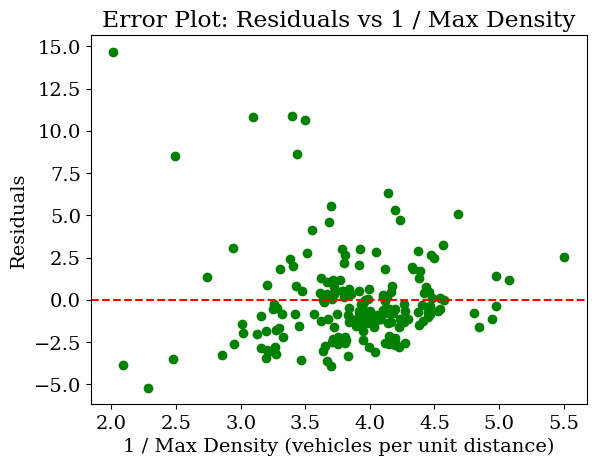

In [27]:
# Calculate residuals
residuals = y_test - y_pred_transformed

# Plotting the error plot
plt.scatter(X_test_transformed, residuals, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('1 / Max Density (vehicles per unit distance)')
plt.ylabel('Residuals')
plt.title('Error Plot: Residuals vs 1 / Max Density')
plt.show()


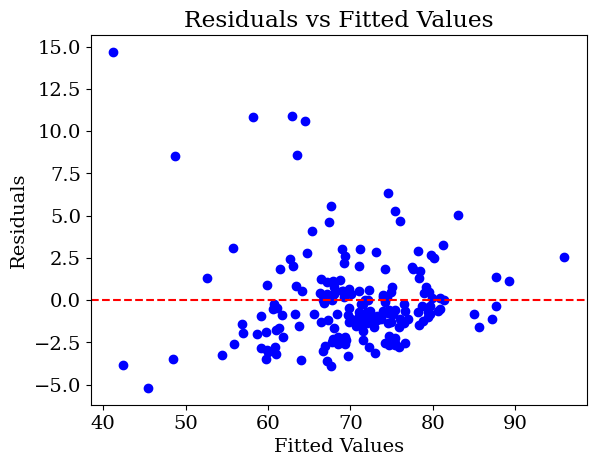

In [29]:
# Calculate fitted values
fitted_values = model_transformed.predict(X_test_transformed)

# Plotting residuals vs fitted values
plt.scatter(fitted_values, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()


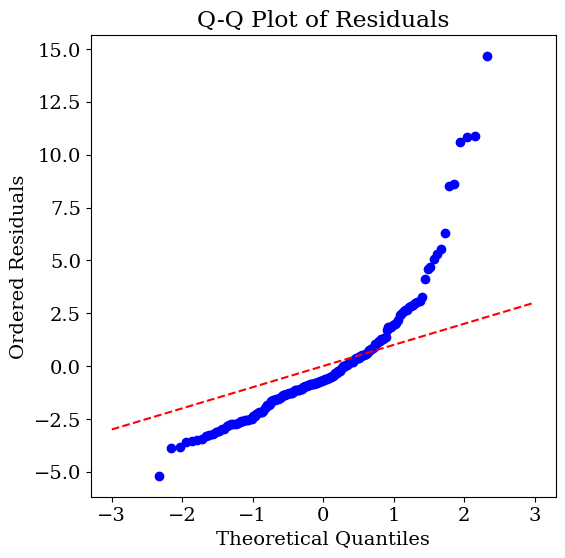

In [28]:
import scipy.stats as stats

# Generate theoretical quantiles
theoretical_quantiles = np.linspace(-3, 3, len(residuals))

# Calculate empirical quantiles of the residuals
residuals_sorted = np.sort(residuals)
empirical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(residuals)))

# Plot Q-Q plot
plt.figure(figsize=(6, 6))
plt.scatter(empirical_quantiles, residuals_sorted, color='blue')
plt.plot(theoretical_quantiles, theoretical_quantiles, color='red', linestyle='--')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Residuals')
plt.title('Q-Q Plot of Residuals')
plt.show()


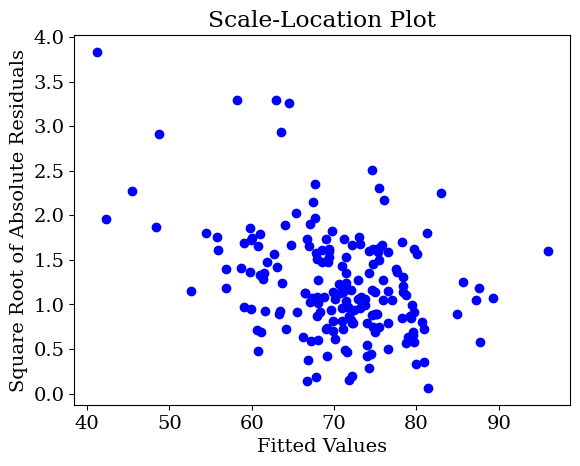

In [30]:
# Calculate square root of absolute residuals
sqrt_abs_residuals = np.sqrt(np.abs(residuals))

# Plotting scale-location plot
plt.scatter(fitted_values, sqrt_abs_residuals, color='blue')
plt.xlabel('Fitted Values')
plt.ylabel('Square Root of Absolute Residuals')
plt.title('Scale-Location Plot')
plt.show()
